In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import nibabel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from skimage.filters import unsharp_mask
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from skimage.transform import resize
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
from dipy.align.imaffine import AffineMap
from dipy.align import resample
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten
from tensorflow.keras.layers import Conv3D, AveragePooling3D, MaxPooling3D
from tensorflow.keras.layers import add, multiply, GlobalAveragePooling3D, GlobalMaxPooling3D, Reshape
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals
import six
from math import ceil

In [15]:
def _bn_relu(input):
    """Helper to build a BN -> relu block (by @raghakot)."""
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)

def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        conv = Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(input)
        return _bn_relu(conv)

    return f

In [16]:
def _bn_relu_conv3d(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(activation)

    return f

def _shortcut3d(input, residual):
    stride_dim1 = ceil(input.shape[DIM1_AXIS] / residual.shape[DIM1_AXIS])
    stride_dim2 = ceil(input.shape[DIM2_AXIS] / residual.shape[DIM2_AXIS])
    stride_dim3 = ceil(input.shape[DIM3_AXIS] / residual.shape[DIM3_AXIS])
    equal_channels = residual.shape[CHANNEL_AXIS] == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal",
            padding="valid",
            kernel_regularizer=l2(1e-4),
        )(input)
    return add([shortcut, residual])

In [17]:
def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        conv = Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(input)
        return _bn_relu(conv)

    return f

def _bn_relu_conv3d(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer,
        )(activation)

    return f

In [18]:
def _shortcut3d(input, residual):
    stride_dim1 = ceil(input.shape[DIM1_AXIS] / residual.shape[DIM1_AXIS])
    stride_dim2 = ceil(input.shape[DIM2_AXIS] / residual.shape[DIM2_AXIS])
    stride_dim3 = ceil(input.shape[DIM3_AXIS] / residual.shape[DIM3_AXIS])
    equal_channels = residual.shape[CHANNEL_AXIS] == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal",
            padding="valid",
            kernel_regularizer=l2(1e-4),
        )(input)
    return add([shortcut, residual])

def _residual_block(
    filters,
    kernel_regularizer,
    is_first_layer=False,
):
    def f(input):
        strides = (2, 2, 2) if not is_first_layer else (1, 1, 1)
        conv1 = _conv_bn_relu3D(
            filters=filters,
            kernel_size=(5, 5, 5),  # Changed kernel size
            strides=strides,
            kernel_regularizer=kernel_regularizer,
        )(input)
        
        conv2 = _conv_bn_relu3D(
            filters=filters,
            kernel_size=(5, 5, 5),  # Changed kernel size
            kernel_regularizer=kernel_regularizer,
        )(conv1)



        
        return _shortcut3d(input, conv2)

    return f

In [19]:
def basic_block(
    filters,
    strides=(1, 1, 1),
    kernel_regularizer=l2(1e-4),
    is_first_block_of_first_layer=False,
):
    def f(input):
        if is_first_block_of_first_layer:
            conv1 = Conv3D(
                filters=filters,
                kernel_size=(5, 5, 5),  # Changed kernel size
                strides=strides,
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer,
            )(input)
        else:
            conv1 = _bn_relu_conv3d(
                filters=filters,
                kernel_size=(5, 5, 5),  # Changed kernel size
                strides=strides,
                kernel_regularizer=kernel_regularizer,
            )(input)

        residual = _bn_relu_conv3d(
            filters=filters,
            kernel_size=(5, 5, 5),  # Changed kernel size
            kernel_regularizer=kernel_regularizer,
        )(conv1)
        return _shortcut3d(input, residual)

    return f

def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == "channels_last":
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4

def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError("Invalid {}".format(identifier))
        return res
    return identifier

class Resnet3DBuilder(object):
    """ResNet3D."""

    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor):
        """Instantiate a vanilla ResNet3D keras model.

        # Arguments
            input_shape: Tuple of input shape in the format
            (conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='tf'
            (filter, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th'
            num_outputs: The number of outputs at the final softmax layer
            block_fn: Unit block to use {'basic_block', 'bottlenack_block'}
            repetitions: Repetitions of unit blocks
        # Returns
            model: a 3D ResNet model that takes a 5D tensor (volumetric images
            in batch) as input and returns a 1D vector (prediction) as output.
        """
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError(
                "Input shape should be a tuple "
                "(conv_dim1, conv_dim2, conv_dim3, channels) "
                "for tensorflow as backend or "
                "(channels, conv_dim1, conv_dim2, conv_dim3) "
                "for theano as backend"
            )

        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        # first conv
        conv1 = _conv_bn_relu3D(
            filters=128,  # Changed filter size
            kernel_size=(5, 5, 5),  # Changed kernel size
            strides=(2, 2, 2),
            kernel_regularizer=l2(reg_factor),
        )(input)
        pool1 = MaxPooling3D(pool_size=(3, 3, 3), strides=(2, 2, 2), padding="same")(
            conv1
        )

        # repeat blocks
        block = pool1
        filters = 128  # Changed filter size
        for i, r in enumerate(repetitions):
            block = _residual_block(
                filters=filters,
                kernel_regularizer=l2(reg_factor),
                is_first_layer=(i == 0),
            )(block)
            filters *= 2

        # last activation
        block_output = _bn_relu(block)

        # average pool and classification
        pool2 = AveragePooling3D(
            pool_size=(
                block.shape[DIM1_AXIS],
                block.shape[DIM2_AXIS],
                block.shape[DIM3_AXIS],
            ),
            strides=(1, 1, 1),
        )(block_output)
        flatten1 = Flatten()(pool2)
        if num_outputs > 1:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="softmax",
                kernel_regularizer=l2(reg_factor),
            )(flatten1)
        else:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="sigmoid",
                kernel_regularizer=l2(reg_factor),
            )(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model



    @staticmethod
    def build_resnet_152(input_shape, num_outputs, reg_factor=1e-4):
        """Build resnet 152."""
        return Resnet3DBuilder.build(
            input_shape, num_outputs, basic_block, [3, 16, 36, 6], reg_factor=reg_factor
        )


In [20]:
# Testing the model
def apply_mask(aseg_image, brain_image, labels = [17, 53, 2, 7, 41, 46]):
    brain_data = aseg_image.get_fdata()
    aseg_data = aseg_image.get_fdata()
    origin_data = brain_image.get_fdata()
    
    brain_mask = np.zeros_like(aseg_data)
    for label in labels:
        brain_mask += np.where((aseg_data == label), 1, 0)

    new_image = origin_data * brain_mask
    
    return new_image

In [21]:
def enhance_slice(slice_data):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_slice = clahe.apply(slice_data.astype(np.uint8))

    return enhanced_slice

def enhance_image(img_data):
    enhanced_image = np.zeros_like(img_data)
    for i in range(img_data.shape[2]):
        enhanced_image[:, :, i] = enhance_slice(img_data[:, :, i])
    return enhanced_image


In [22]:
def sharpen_image(image, strength=1.0):
    sharpened_image = unsharp_mask(image, radius=1, amount=strength)
    return sharpened_image

def apply_nonlinear_registration(moving_image, fixed_image):
    metric = CCMetric(3)

    sdr = SymmetricDiffeomorphicRegistration(metric, [10, 10, 10], step_length=0.25, ss_sigma_factor=1.5)

    mapping = sdr.optimize(fixed_image, moving_image)

    warped_moving_image = mapping.transform(moving_image)

    return warped_moving_image


In [23]:
def image_fixed(image_type, target_shape):
    aseg_image = nibabel.load('/home/fahim/Documents/FYDP/datasets/oasis1/dataset/AD/OAS1_0028_MR1_1')
    base_path = "/home/fahim/Documents/FYDP/datasets/oasis1/dataset/AD/OAS1_0028_MR1_1/mri/orig.mgz"
    origin_image =  nibabel.load(base_path)
    
    if (image_type == 'roi') :
        image = apply_mask(aseg_image, origin_image)
        image = resize(image, target_shape, anti_aliasing=True)
        image = sharpen_image(image)
        return image


In [24]:
from scipy.ndimage import rotate


In [25]:
def augment(image, rotation_range):
    rotation_angle = np.random.uniform(-rotation_range, rotation_range)
    rotated_image = rotate(image, rotation_angle, reshape=False)
    
    return rotated_image



def image_loader_roi(image_path, target_shape, type_dt=''):
    aseg_image = nibabel.load(image_path)
    base_path = "/".join(image_path.split('/')[:-1]) + "/orig.mgz"
    base_image =  nibabel.load(base_path)
    
    image = apply_mask(aseg_image, base_image)
    image = resize(image, target_shape, anti_aliasing=True)
    image = enhance_image(image)
    image = sharpen_image(image)
    
    if type_dt=='train':
        image = augment(image, 50)

    return image

In [26]:
def data_generator(paths, labels, batch_size, target_shape, image_type, type_dt=''):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batch_images = []
            
    
            if image_type == 'roi':
                batch_images = [image_loader_roi(image, target_shape, type_dt) for image in batch_paths]


            batch_images = np.stack([batch_images] * 1, axis=-1)

            batch_labels = to_categorical(batch_labels, num_classes=2)
            yield np.array(batch_images), batch_labels
base_dir = '/home/fahim/Documents/FYDP/datasets/oasis1/dataset'
ad = os.path.join(base_dir, 'AD')
mci = os.path.join(base_dir, 'MCI')
cn = os.path.join(base_dir, 'CN')
# original shape (257, 257, 257)

ad_images= []
mci_images = []
cn_images = []

for subject_dir in os.listdir(ad):
    mri_path = os.path.join(ad, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    if not (len(os.listdir(os.path.join(ad, subject_dir, 'mri'))) < 6):
        ad_images.append(mri_path)
        
for subject_dir in os.listdir(mci):
    mri_path = os.path.join(mci, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    
    if not (len(os.listdir(os.path.join(mci, subject_dir, 'mri'))) < 6):
        mci_images.append(mri_path)
        
for subject_dir in os.listdir(cn):
    mri_path = os.path.join(cn, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    if not (len(os.listdir(os.path.join(cn, subject_dir, 'mri'))) < 6):
        cn_images.append(mri_path)


image_path = ad_images + cn_images + cn_images[:len(ad_images)-len(cn_images)]
labels = [0] * len(ad_images) + [1] * len(cn_images) + [1] * len(cn_images[:len(ad_images)-len(cn_images)])
train_paths, test_paths, train_labels, test_labels = train_test_split(image_path, labels, test_size = 0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)
test_paths = np.array(test_paths)
test_labels = np.array(test_labels)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)
test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

target_shape = (100, 100, 100)
batch_size = 10
selection_type = 'roi'
train_dataset = data_generator(train_paths, train_labels, batch_size, target_shape, 
                               image_type=selection_type, 
                               type_dt='train'
                              )

test_dataset = data_generator(test_paths, test_labels, batch_size, target_shape, 
                              image_type=selection_type
                             )
len(test_paths), len(train_labels), class_weights


(307, 1228, array([6.46315789, 0.5419241 ]))

In [27]:
from tensorflow.keras.optimizers import Adam

In [28]:
classes = 2
image_shape = (*target_shape, 1)
model = Resnet3DBuilder.build_resnet_152(input_shape = image_shape, num_outputs=classes)

model.compile(
    optimizer=Adam(0.00001), 
    loss='binary_crossentropy', 
    metrics=['accuracy', 'Recall', 'AUC', 'Precision'] 
)
model.summary()

NameError: name 'six' is not defined

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [23]:
model_checkpoint = ModelCheckpoint('Upgrade_Filter_6ROI_WithoutCBAM_OASIS_ADvsCN.h5', monitor='val_accuracy', mode='max', save_best_only=True)

num_epoch = 50
history = model.fit(
    train_dataset,
    epochs=num_epoch,
    steps_per_epoch=len(train_paths) // batch_size,
    validation_data=test_dataset,
    validation_steps=len(test_paths) // batch_size,
    callbacks=[model_checkpoint]  
)

Epoch 1/50
122/122 [==============================] - 2145s 12s/step - loss: 1.5868 - accuracy: 0.8410 - recall: 0.8410 - auc: 0.8791 - precision: 0.8410 - val_loss: 1.4545 - val_accuracy: 0.9267 - val_recall: 0.9267 - val_auc: 0.9593 - val_precision: 0.9267
Epoch 2/50
122/122 [==============================] - 1442s 12s/step - loss: 1.4108 - accuracy: 0.9117 - recall: 0.9117 - auc: 0.9460 - precision: 0.9117 - val_loss: 1.3884 - val_accuracy: 0.9267 - val_recall: 0.9267 - val_auc: 0.9640 - val_precision: 0.9267
Epoch 3/50
122/122 [==============================] - 1450s 12s/step - loss: 1.3683 - accuracy: 0.9125 - recall: 0.9125 - auc: 0.9512 - precision: 0.9125 - val_loss: 1.4242 - val_accuracy: 0.9267 - val_recall: 0.9267 - val_auc: 0.9669 - val_precision: 0.9267
Epoch 4/50
122/122 [==============================] - 1483s 12s/step - loss: 1.3258 - accuracy: 0.9172 - recall: 0.9172 - auc: 0.9597 - precision: 0.9172 - val_loss: 1.5188 - val_accuracy: 0.8600 - val_recall: 0.8600 - val_

In [24]:
saved_model = tf.keras.models.load_model('Upgrade_Filter_6ROI_WithoutCBAM_OASIS_ADvsCN.h5')
test_accuracy = saved_model.evaluate(
    test_dataset,
    steps=len(test_paths) // batch_size,
    verbose=1
)
print("Test Accuracy:", test_accuracy)

30/30 [==============================] - 264s 9s/step - loss: 0.9664 - accuracy: 0.9933 - recall: 0.9933 - auc: 0.9998 - precision: 0.9933
Test Accuracy: [0.9664092063903809, 0.9933333396911621, 0.9933333396911621, 0.9997777342796326, 0.9933333396911621]


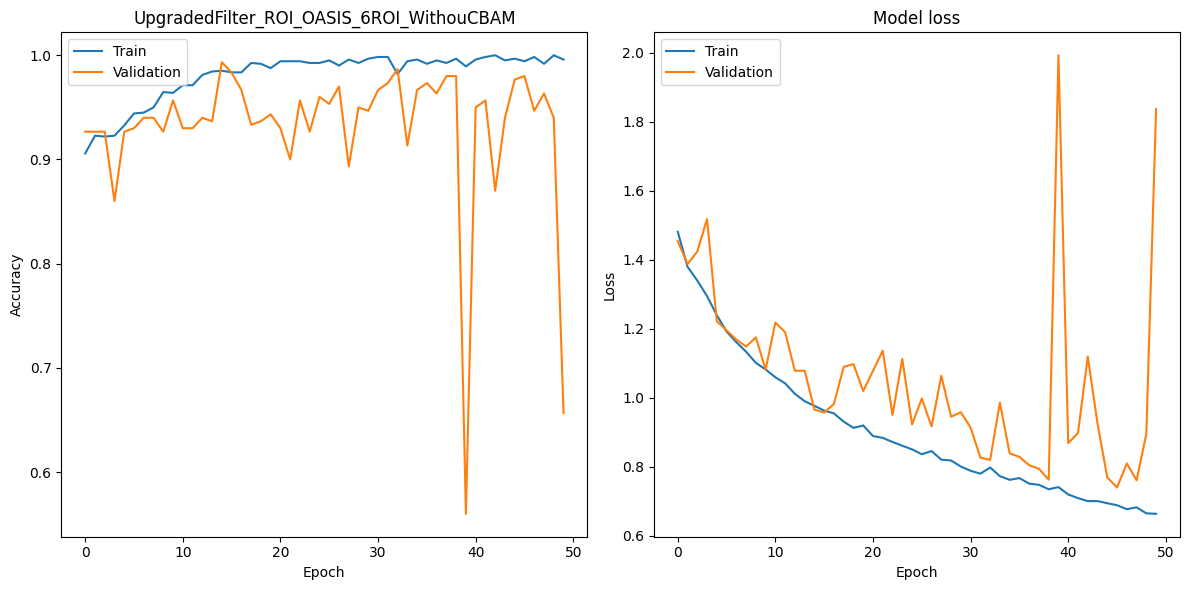

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('UpgradedFilter_ROI_OASIS_6ROI_WithouCBAM')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("UpgradedFilter_ROI_OASIS_6ROI_WithouCBAM.png")

plt.tight_layout()
plt.show()

In [6]:
from tensorflow.keras.models import load_model

model = load_model('Upgrade_Filter_6ROI_WithoutCBAM_OASIS_ADvsCN.h5')

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [9]:

# Load the saved model
saved_model = tf.keras.models.load_model('Upgrade_Filter_6ROI_WithoutCBAM_OASIS_ADvsCN.h5')

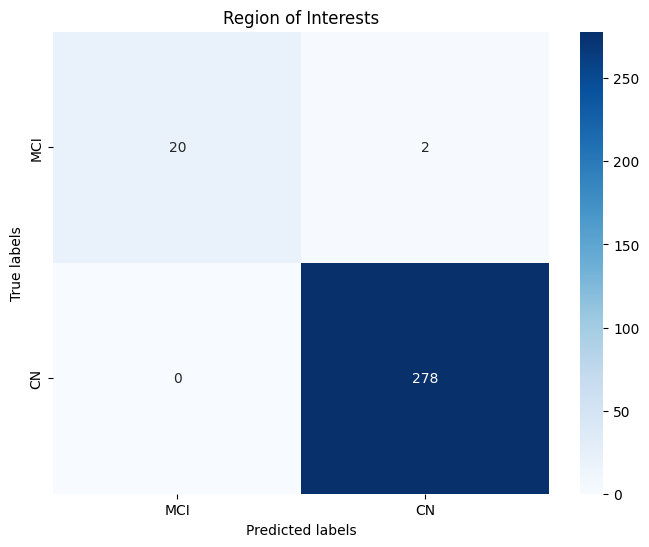

In [30]:

predictions = saved_model.predict(test_dataset, steps=len(test_paths) // batch_size)
predicted_labels = np.argmax(predictions, axis=1)


conf_matrix = confusion_matrix(test_labels[:len(predicted_labels)], predicted_labels)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['MCI', 'CN'], yticklabels=['MCI', 'CN'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Region of Interests')
plt.savefig('confusion_matrix_6ROI.png')


plt.show()
